In [1]:
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel
from pathlib import Path
import matplotlib.pyplot as plt
import json
import pandas as pd

## Nile example

Let us consider here the following system fitted to the Nile river dataset often used to illustrate time series modeling. Check <url>https://mjlaine.github.io/dlm/dlmtut.html</url> for some more details about the example.


<img src="https://latex.codecogs.com/svg.image?A&space;=&space;\begin{bmatrix}1&space;&&space;1&space;\\0&space;&&space;1\end{bmatrix},&space;\&space;C&space;=&space;&space;\begin{bmatrix}1&space;&&space;0&space;\end{bmatrix},&space;\&space;R&space;=&space;\theta_1^2,&space;\&space;Q&space;=&space;&space;\begin{bmatrix}\theta_2^2&space;&&space;0&space;\\0&space;&&space;\theta_3^2&space;\end{bmatrix}" title="A = \begin{bmatrix}1 & 1 \\0 & 1\end{bmatrix}, \ C = \begin{bmatrix}1 & 0 \end{bmatrix}, \ R = \theta_1^2, \ Q = \begin{bmatrix}\theta_2^2 & 0 \\0 & \theta_3^2 \end{bmatrix}" align="left"/>

### 1) Define the functions that build the needed matrices

Here, we write a Stan functions block that builds the matrices given the parameters. Note that the noise parameters are separated from the "other" parameters so that we can assign priors separately for them (e.g. enforce positivity). Note that here we don't have any model parameters, just some noise parameters. Note also that we don't have the $B$ matrix here, so we just define a dummy zero matrix so that we can apply the general DLM code.

In [2]:
nile_functions = """
functions {
    matrix build_A(vector theta) {
        matrix[2,2] A;
        A[1,1] = 1;
        A[1,2] = 1;
        A[2,1] = 0;
        A[2,2] = 1;
        return A;
    }
    matrix build_B(vector theta) {
        matrix[2,1] B;
        B[1,1] = 0;
        B[2,1] = 0;
        return B;
    }
    matrix build_C(vector theta) {
        matrix[1,2] C;
        C[1,1] = 1;
        C[1,2] = 0;
        return C;
    }
    matrix build_Q(vector noise_theta) {
        matrix[2,2] Q;
        Q[1,1] = square(noise_theta[2]);
        Q[2,2] = square(noise_theta[3]);
        Q[1,2] = 0;
        Q[2,1] = 0;
        return Q;
    }
    matrix build_R(vector noise_theta) {
        matrix[1,1] R;
        R[1,1] = square(noise_theta[1]);
        return R;
    }
}
"""

### 2) Compile the code with `CmdStanPy`

First, we read the general DLM stan code and append the user-defined functions to the model file.

In [3]:
dlm_code = Path('../dlm.stan').read_text()
Path('nile.stan').write_text(nile_functions + dlm_code);
nile_model = CmdStanModel(stan_file='nile.stan')

INFO:cmdstanpy:compiling stan program, exe file: /home/solant/src/dlmstan/examples/nile
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/solant/src/dlmstan/examples/nile


### 3) Construct the data

The general DLM code always needs the same input data variables. Note that the vectors and matrices need to be given as python lists so that the serialization to JSON works.

In [4]:
y = [1120, 1160, 963, 1210, 1160, 1160, 813, 1230, 1370, 1140, 995, 935,
     1110, 994, 1020, 960, 1180, 799, 958, 1140, 1100, 1210, 1150, 1250,
     1260, 1220, 1030, 1100, 774, 840, 874, 694, 940, 833, 701, 916,
     692, 1020, 1050,  969,  831, 726, 456, 824, 702, 1120, 1100, 832, 764,
     821, 768, 845, 864, 862, 698, 845, 744, 796, 1040, 759, 781, 865,
     845, 944, 984, 897, 822, 1010, 771, 676, 649, 846, 812, 742, 801,
     1040, 860, 874, 848, 890, 744, 749, 838, 1050, 918, 986, 797, 923,
     975, 815, 1020, 906, 901, 1170, 912, 746, 919, 718, 714, 740]

nile_data = {
    'N_obs': len(y),
    'N_theta': 1, # dummy theta
    'N_noise_theta': 3,
    'state_dim': 2,
    'input_dim': 1, # dummy input
    'obs_dim': 1,
    'Y_obs': [[yi] for yi in y],
    'U_obs': len(y)*[[0.]], # dummy
    'm0': [1100.0, 0.0],
    'P0': [[200.**2, 0], [0, 1.**2]],
    'theta_mu': [0.], # dummy
    'theta_Sig': [[1.]], # dummy
    'noise_mu': [100., 10., 10.],
    'noise_Sig': [[10.**2, 0, 0], [0, 10**2, 0], [0,0,10**2]]
}

In [5]:
with open('nile_data.json', 'w') as f:
    json.dump(nile_data, f)

## 4) Fit the model with HMC

Save the output files to a separate output folder to keep things clean. Print the fit object to get some details about the files that were produced.

In [6]:
nile_fit = nile_model.sample(data='nile_data.json', output_dir='output')
print(nile_fit)

INFO:cmdstanpy:created output directory: /home/solant/src/dlmstan/examples/output
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2


CmdStanMCMC: model=nile chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/home/solant/src/dlmstan/examples/output/nile-202105170847-1.csv
	/home/solant/src/dlmstan/examples/output/nile-202105170847-2.csv
	/home/solant/src/dlmstan/examples/output/nile-202105170847-3.csv
	/home/solant/src/dlmstan/examples/output/nile-202105170847-4.csv
 output_files:
	/home/solant/src/dlmstan/examples/output/nile-202105170847-1-stdout.txt
	/home/solant/src/dlmstan/examples/output/nile-202105170847-2-stdout.txt
	/home/solant/src/dlmstan/examples/output/nile-202105170847-3-stdout.txt
	/home/solant/src/dlmstan/examples/output/nile-202105170847-4-stdout.txt


## 5) Access the parameters and plot results

Let us draw the sampled states and parameters. Sampled parameters can be accessed with `CmdStanPy`:s helper `stan_variable`.

In [7]:
draws_noise = nile_fit.stan_variable(name='noise_theta')
draws_x = nile_fit.stan_variable(name='x_samples')

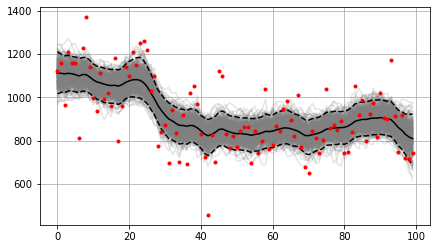

In [8]:
plt.figure(figsize=(7,4))

plt.plot(range(len(y)), draws_x[0::10,:,0].T, c='0.5', alpha=0.2)
plt.plot(range(len(y)), np.quantile(draws_x[0:,:,0].T, [0.025, 0.975], axis=1).T, 'k--')
plt.plot(range(len(y)), np.quantile(draws_x[0:,:,0].T, 0.5, axis=1), 'k-')
plt.plot(range(len(y)), y, 'r.')

plt.grid(True)
plt.show()

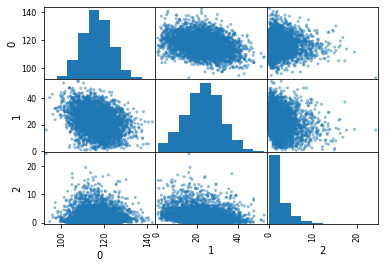

In [9]:
pd.plotting.scatter_matrix(pd.DataFrame(draws_noise));